# Objective

In this **phase**, the goal was to **develop intelligent features** and undertake an **Exploratory Data Analysis (EDA)** to refine the original dataset into a **smart and valuable dataset(usable form)**. A key step of this phase was to define all **hidden patterns**, **customer behaviors**, and **business signals**, while also developing features such as **RFM metrics**, **aggregated purchase behaviors**, and **time-based features**; all of which were intended for further preparing the dataset for effective and valid **machine learning models**.

**Feature engineering** is the process of **creating new input variables (features) or transforming existing ones to improve model performance**.

**EDA(Exploratory Data Analysis)** is the process of **analyzing datasets visually and statistically to uncover patterns, relationships, anomalies, data quality issues**.





# Import Libraries

In [1]:
        # For data manipulation
import pandas as pd
import numpy as np

        # For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime        # For data Manipulating (date time) 

        # For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)
    
print("Libraries loaded successfully!")

Libraries loaded successfully!


# Load all CSV datasets

In [2]:
# Load the master_df (created from 01_Olist_Data_Integration.ipynb)
# Also loading individual tables for feature engineering
try:
    master_df = pd.read_csv(r'/Users/apple/Documents/data projects/Olist project/Olist_master_dataframe.csv', 
                            parse_dates=[
        'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
        'order_delivered_customer_date', 'order_estimated_delivery_date',
        'shipping_limit_date', 'review_creation_date', 'review_answer_timestamp'
    ])
    # Load individual tables for more granular feature engineering
    customers_df = pd.read_csv(r'/Users/apple/Documents/data projects/Olist project/Olist data unmerged/olist_customers_dataset.csv')
    orders_df = pd.read_csv(r'/Users/apple/Documents/data projects/Olist project/Olist data unmerged/olist_orders_dataset.csv', 
                                    parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
    order_items_df = pd.read_csv(r'/Users/apple/Documents/data projects/Olist project/Olist data unmerged/olist_order_items_dataset.csv')
    order_payments_df = pd.read_csv(r'/Users/apple/Documents/data projects/Olist project/Olist data unmerged/olist_order_payments_dataset.csv')
    order_reviews_df = pd.read_csv(r'/Users/apple/Documents/data projects/Olist project/Olist data unmerged/olist_order_reviews_dataset.csv', 
                                   parse_dates=['review_creation_date', 'review_answer_timestamp'])
    products_df = pd.read_csv(r'/Users/apple/Documents/data projects/Olist project/Olist data unmerged/olist_products_dataset.csv')
    sellers_df = pd.read_csv(r'/Users/apple/Documents/data projects/Olist project/Olist data unmerged/olist_sellers_dataset.csv')
           # Need seller info for new features
    product_category_translation_df = pd.read_csv(r'/Users/apple/Documents/data projects/Olist project/Olist data unmerged/product_category_name_translation.csv')

    print("Master and individual dataframes loaded successfully!")
    print(f"master_df shape: {master_df.shape}")
    print(f"orders_df shape: {orders_df.shape}")
    print(f"order_items_df shape: {order_items_df.shape}")
    print(f"products_df shape: {products_df.shape}")
    print(f"order_payments_df shape: {order_payments_df.shape}")
    print(f"order_reviews_df shape: {order_reviews_df.shape}")
    print(f"product_category_translation_df shape: {product_category_translation_df.shape}")
    print(f"customers_df shape: {customers_df.shape}")
    print(f"sellers_df shape: {sellers_df.shape}")

except FileNotFoundError:
    print("Error: One or more CSV files not found. Please ensure all Olist datasets are in the '../data/' directory and 'olist_master_dataframe.csv' is created from 01_Olist_Data_Integration.ipynb")
    exit()
    

Master and individual dataframes loaded successfully!
master_df shape: (118307, 40)
orders_df shape: (99441, 8)
order_items_df shape: (112650, 7)
products_df shape: (32951, 9)
order_payments_df shape: (103886, 5)
order_reviews_df shape: (99224, 7)
product_category_translation_df shape: (71, 2)
customers_df shape: (99441, 5)
sellers_df shape: (3095, 4)


# Exploratory Data Analysis (EDA)

In [3]:
# Merge product category names to products_df for easier use
products_df = pd.merge(products_df, product_category_translation_df, on='product_category_name', how='left')
# Fill missing English names with original Portuguese if translation is missing
products_df['product_category_name_english'] = products_df['product_category_name_english'].fillna(products_df['product_category_name'])
print("Product category names translated in products_df.")

Product category names translated in products_df.


In [4]:
# Ensure master_df has 'customer_unique_id' (should be there from 01 notebook, but lets check since it is Important for analysis)
if 'customer_unique_id' not in master_df.columns:
    master_df = pd.merge(master_df, customers_df[['customer_id', 'customer_unique_id']], on='customer_id', how='left')
    print("Added 'customer_unique_id' to master_df.")

In [5]:
print("\n     Performing RFM Analysis (Recency, Frequency, Monetary)      ")

# Calculate a snapshot date (e.g., day after the last order in the dataset)
snapshot_date = master_df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)
print(f"RFM Snapshot Date: {snapshot_date}")


     Performing RFM Analysis (Recency, Frequency, Monetary)      
RFM Snapshot Date: 2018-09-04 09:06:57


In [6]:
# Group by customer_unique_id for RFM metrics
# Initial Monetary calculation (sum of item prices)
rfm_df = master_df.groupby('customer_unique_id').agg(
    Recency=('order_purchase_timestamp', lambda date: (snapshot_date - date.max()).days),
    Frequency=('order_id', 'nunique'),
    Total_Product_Price=('price', 'sum') # Temporary column for item prices
).reset_index()

print(rfm_df.head())

                 customer_unique_id  Recency  Frequency  Total_Product_Price
0  0000366f3b9a7992bf8c76cfdf3221e2      116          1               129.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f      119          1                18.90
2  0000f46a3911fa3c0805444483337064      542          1                69.00
3  0000f6ccb0745a6a4b88665a16c9f078      326          1                25.99
4  0004aac84e0df4da2b147fca70cf8255      293          1               180.00


In [7]:
# Add Total_Freight_Value per customer to get true Monetary
customer_total_freight = master_df.groupby('customer_unique_id')['freight_value'].sum().reset_index(name='Total_Freight_Value')
print(customer_total_freight.head())

rfm_df = pd.merge(rfm_df, customer_total_freight, on='customer_unique_id', how='left')
rfm_df['Monetary'] = rfm_df['Total_Product_Price'] + rfm_df['Total_Freight_Value']

rfm_df.head()

                 customer_unique_id  Total_Freight_Value
0  0000366f3b9a7992bf8c76cfdf3221e2                12.00
1  0000b849f77a49e4a4ce2b2a4ca5be3f                 8.29
2  0000f46a3911fa3c0805444483337064                17.22
3  0000f6ccb0745a6a4b88665a16c9f078                17.63
4  0004aac84e0df4da2b147fca70cf8255                16.89


,customer_unique_id,Recency,Frequency,Total_Product_Price,Total_Freight_Value,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,12.00,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,8.29,27.19
2,0000f46a3911fa3c0805444483337064,542,1,69.00,17.22,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,17.63,43.62
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,16.89,196.89


In [8]:
# Drop the temporary price and freight columns
rfm_df.drop(columns=['Total_Product_Price', 'Total_Freight_Value'], inplace=True)

rfm_df.head()


,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19
2,0000f46a3911fa3c0805444483337064,542,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89


In [9]:
# Add customer tenure (days since their first purchase)
customer_first_purchase = master_df.groupby('customer_unique_id')['order_purchase_timestamp'].min().reset_index(name='first_purchase_date')
rfm_df = pd.merge(rfm_df, customer_first_purchase, on='customer_unique_id', how='left')
rfm_df['customer_tenure_days'] = (snapshot_date - rfm_df['first_purchase_date']).dt.days
rfm_df.drop(columns=['first_purchase_date'], inplace=True) # Clean up temporary column

rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary,customer_tenure_days
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,119
2,0000f46a3911fa3c0805444483337064,542,1,86.22,542
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,326
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,293


In [10]:
# Add average review score
customer_avg_review_score = master_df.groupby('customer_unique_id')['review_score'].mean().reset_index(name='average_review_score')
rfm_df = pd.merge(rfm_df, customer_avg_review_score, on='customer_unique_id', how='left')

rfm_df.head()


,customer_unique_id,Recency,Frequency,Monetary,customer_tenure_days,average_review_score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,116,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,119,4.0
2,0000f46a3911fa3c0805444483337064,542,1,86.22,542,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,326,4.0
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,293,5.0


In [11]:
# Add number of unique product categories purchased
customer_unique_categories = master_df.groupby('customer_unique_id')['product_category_name_english'].nunique().reset_index(name='num_unique_product_categories_purchased')
rfm_df = pd.merge(rfm_df, customer_unique_categories, on='customer_unique_id', how='left')

rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary,customer_tenure_days,average_review_score,num_unique_product_categories_purchased
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,116,5.0,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,119,4.0,1
2,0000f46a3911fa3c0805444483337064,542,1,86.22,542,3.0,1
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,326,4.0,1
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,293,5.0,1


## ADVANCED FEATURE ENGINEERING

In [12]:
# Create a comprehensive DataFrame with customer_unique_id at the item level
# This simplifies all subsequent customer_unique_id based aggregations
customer_order_item_product_df = pd.merge(order_items_df, products_df[['product_id', 'product_category_name_english']], on='product_id', how='left')
customer_order_item_product_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,garden_tools


In [13]:
customer_order_item_product_df = pd.merge(customer_order_item_product_df, orders_df[['order_id', 'customer_id']], on='order_id', how='left')
customer_order_item_product_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name_english,customer_id
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,3ce436f183e68e07877b285a838db11a
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,f6dd3ec061db4e3987629fe6b26e5cce
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,furniture_decor,6489ae5e4333f3693df5ad4372dab6d3
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumery,d4eb9395c8c0431ee92fce09860c5a06
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,garden_tools,58dbd0b2d70206bf40e62cd34e84d795


In [14]:
customer_order_item_product_df = pd.merge(customer_order_item_product_df, customers_df[['customer_id', 'customer_unique_id']], on='customer_id', how='left')
customer_order_item_product_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name_english,customer_id,customer_unique_id
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,furniture_decor,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumery,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,garden_tools,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5


In [15]:
customer_order_item_product_df.drop(columns=['customer_id'], inplace=True) # customer_unique_id is preferred for final RFM merge
customer_order_item_product_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name_english,customer_unique_id
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,871766c5855e863f6eccc05f988b23cb
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,eb28e67c4c0b83846050ddfb8a35d051
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,furniture_decor,3818d81c6709e39d06b2738a8d3a2474
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumery,af861d436cfc08b2c2ddefd0ba074622
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,garden_tools,64b576fb70d441e8f1b2d7d446e483c5


In [16]:
# 1. Price-Related Features
print("  - Calculating Price-Related Features...")
customer_avg_product_price = customer_order_item_product_df.groupby('customer_unique_id')['price'].mean().reset_index(name='avg_product_price_per_customer')
rfm_df = pd.merge(rfm_df, customer_avg_product_price, on='customer_unique_id', how='left')

rfm_df.head()

  - Calculating Price-Related Features...


,customer_unique_id,Recency,Frequency,Monetary,customer_tenure_days,average_review_score,num_unique_product_categories_purchased,avg_product_price_per_customer
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,116,5.0,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,119,4.0,1,18.90
2,0000f46a3911fa3c0805444483337064,542,1,86.22,542,3.0,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,326,4.0,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,293,5.0,1,180.00


In [17]:
customer_max_product_price = customer_order_item_product_df.groupby('customer_unique_id')['price'].max().reset_index(name='max_product_price_purchased')
rfm_df = pd.merge(rfm_df, customer_max_product_price, on='customer_unique_id', how='left')
rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary,customer_tenure_days,average_review_score,num_unique_product_categories_purchased,avg_product_price_per_customer,max_product_price_purchased
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,116,5.0,1,129.90,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,119,4.0,1,18.90,18.90
2,0000f46a3911fa3c0805444483337064,542,1,86.22,542,3.0,1,69.00,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,326,4.0,1,25.99,25.99
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,293,5.0,1,180.00,180.00


In [18]:
customer_min_product_price = customer_order_item_product_df.groupby('customer_unique_id')['price'].min().reset_index(name='min_product_price_purchased')
rfm_df = pd.merge(rfm_df, customer_min_product_price, on='customer_unique_id', how='left')

rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary,customer_tenure_days,average_review_score,num_unique_product_categories_purchased,avg_product_price_per_customer,max_product_price_purchased,min_product_price_purchased
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,116,5.0,1,129.90,129.90,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,119,4.0,1,18.90,18.90,18.90
2,0000f46a3911fa3c0805444483337064,542,1,86.22,542,3.0,1,69.00,69.00,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,326,4.0,1,25.99,25.99,25.99
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,293,5.0,1,180.00,180.00,180.00


In [19]:
customer_avg_freight_per_item = customer_order_item_product_df.groupby('customer_unique_id')['freight_value'].mean().reset_index(name='avg_freight_per_item')
rfm_df = pd.merge(rfm_df, customer_avg_freight_per_item, on='customer_unique_id', how='left')

rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary,customer_tenure_days,average_review_score,num_unique_product_categories_purchased,avg_product_price_per_customer,max_product_price_purchased,min_product_price_purchased,avg_freight_per_item
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,116,5.0,1,129.90,129.90,129.90,12.00
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,119,4.0,1,18.90,18.90,18.90,8.29
2,0000f46a3911fa3c0805444483337064,542,1,86.22,542,3.0,1,69.00,69.00,69.00,17.22
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,326,4.0,1,25.99,25.99,25.99,17.63
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,293,5.0,1,180.00,180.00,180.00,16.89


In [20]:
# 2. Payment-Related Features (from order_payments_df)
print("  - Calculating Payment-Related Features...")
# Need to link order_payments_df to customer_unique_id via orders_df
orders_payments_customers = pd.merge(order_payments_df, orders_df[['order_id', 'customer_id']], on='order_id', how='inner')
orders_payments_customers = pd.merge(orders_payments_customers, customers_df[['customer_id', 'customer_unique_id']], on='customer_id', how='inner')
orders_payments_customers.head()

  - Calculating Payment-Related Features...


,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,customer_unique_id
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,0a8556ac6be836b46b3e89920d59291c,708ab75d2a007f0564aedd11139c7708
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,f2c7fc58a9de810828715166c672f10a,a8b9d3a27068454b1c98cc67d4e31e6f
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,25b14b69de0b6e184ae6fe2755e478f9,6f70c0b2f7552832ba46eb57b1c5651e
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,7a5d8efaaa1081f800628c30d2b0728f,87695ed086ebd36f20404c82d20fca87
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,15fd6fb8f8312dbb4674e4518d6fa3b3,4291db0da71914754618cd789aebcd56


In [21]:
# Average, Max, Min Number of Installments per customer
customer_installments = orders_payments_customers.groupby('customer_unique_id')['payment_installments'].agg(
    avg_installments='mean',
    max_installments='max',
    min_installments='min'
).reset_index()
rfm_df = pd.merge(rfm_df, customer_installments, on='customer_unique_id', how='left')
print(rfm_df.head())

# Most Common Payment Type (One-Hot Encode top N)
top_payment_types = orders_payments_customers['payment_type'].value_counts().nlargest(5).index.tolist()
customer_payment_types_ohe = pd.pivot_table(orders_payments_customers,
                                            index='customer_unique_id',
                                            columns='payment_type',
                                            aggfunc='size',
                                            fill_value=0).reset_index()

# Select only top payment types for OHE and rename columns
customer_payment_types_ohe.columns = ['customer_unique_id'] + [f'payment_type_{col}' for col in customer_payment_types_ohe.columns[1:]]
rfm_df = pd.merge(rfm_df, customer_payment_types_ohe, on='customer_unique_id', how='left').fillna(0)

rfm_df.head()

                 customer_unique_id  Recency  Frequency  Monetary  \
0  0000366f3b9a7992bf8c76cfdf3221e2      116          1    141.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      119          1     27.19   
2  0000f46a3911fa3c0805444483337064      542          1     86.22   
3  0000f6ccb0745a6a4b88665a16c9f078      326          1     43.62   
4  0004aac84e0df4da2b147fca70cf8255      293          1    196.89   

   customer_tenure_days  average_review_score  \
0                   116                   5.0   
1                   119                   4.0   
2                   542                   3.0   
3                   326                   4.0   
4                   293                   5.0   

   num_unique_product_categories_purchased  avg_product_price_per_customer  \
0                                        1                          129.90   
1                                        1                           18.90   
2                                        1              

,customer_unique_id,Recency,Frequency,Monetary,customer_tenure_days,average_review_score,num_unique_product_categories_purchased,avg_product_price_per_customer,max_product_price_purchased,min_product_price_purchased,avg_freight_per_item,avg_installments,max_installments,min_installments,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,116,5.0,1,129.90,129.90,129.90,12.00,8.0,8,8,0,1,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,119,4.0,1,18.90,18.90,18.90,8.29,1.0,1,1,0,1,0,0,0
2,0000f46a3911fa3c0805444483337064,542,1,86.22,542,3.0,1,69.00,69.00,69.00,17.22,8.0,8,8,0,1,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,326,4.0,1,25.99,25.99,25.99,17.63,4.0,4,4,0,1,0,0,0
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,293,5.0,1,180.00,180.00,180.00,16.89,6.0,6,6,0,1,0,0,0


In [22]:
#      Product Category Hotness/Value
print("  - Calculating Product Category Features...")
# Calculate average item price per category
avg_item_price_per_category = customer_order_item_product_df.groupby('product_category_name_english')['price'].mean().reset_index(name='avg_category_item_price')
print(avg_item_price_per_category.head())



  - Calculating Product Category Features...
  product_category_name_english  avg_category_item_price
0    agro_industry_and_commerce               342.124858
1              air_conditioning               185.269226
2                           art               115.802105
3         arts_and_craftmanship                75.583750
4                         audio               139.254121


In [23]:
# Merge this average category price back to the customer_order_item_product_df
customer_order_item_product_df = pd.merge(customer_order_item_product_df, avg_item_price_per_category, on='product_category_name_english', how='left')
print(customer_order_item_product_df.head())



                           order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value product_category_name_english  \
0  2017-09-19 09:45:35   58.90          13.29                    cool_stuff   
1  2017-05-03 11:05:13  239.90          19.93                      pet_shop   

In [24]:
# Customer's average category "value" (using avg_category_item_price as proxy)
customer_avg_purchased_category_price = customer_order_item_product_df.groupby('customer_unique_id')['avg_category_item_price'].mean().reset_index(name='avg_purchased_category_price')
rfm_df = pd.merge(rfm_df, customer_avg_purchased_category_price, on='customer_unique_id', how='left')

rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary,customer_tenure_days,average_review_score,num_unique_product_categories_purchased,avg_product_price_per_customer,max_product_price_purchased,min_product_price_purchased,avg_freight_per_item,avg_installments,max_installments,min_installments,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,avg_purchased_category_price
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,116,5.0,1,129.90,129.90,129.90,12.00,8.0,8,8,0,1,0,0,0,93.296327
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,119,4.0,1,18.90,18.90,18.90,8.29,1.0,1,1,0,1,0,0,0,130.163531
2,0000f46a3911fa3c0805444483337064,542,1,86.22,542,3.0,1,69.00,69.00,69.00,17.22,8.0,8,8,0,1,0,0,0,91.753369
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,326,4.0,1,25.99,25.99,25.99,17.63,4.0,4,4,0,1,0,0,0,71.213978
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,293,5.0,1,180.00,180.00,180.00,16.89,6.0,6,6,0,1,0,0,0,71.213978


In [25]:
# Top N Category Purchase Flags (like did they buy from "electronics")
# Identify categories that historically contribute to high Monetary value (adjust based on your EDA/business knowledge)
high_value_categories_flags = ['health_beauty', 'computers_accessories', 'furniture_decor', 'auto', 'telephony']
for category in high_value_categories_flags:
    # Ensure master_df has customer_unique_id and product_category_name_english
    customer_has_category = master_df.groupby('customer_unique_id')['product_category_name_english'].apply(lambda x: int(category in x.values)).reset_index(name=f'has_category_{category}')
    rfm_df = pd.merge(rfm_df, customer_has_category, on='customer_unique_id', how='left')
    
rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary,customer_tenure_days,average_review_score,num_unique_product_categories_purchased,avg_product_price_per_customer,max_product_price_purchased,min_product_price_purchased,avg_freight_per_item,avg_installments,max_installments,min_installments,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,avg_purchased_category_price,has_category_health_beauty,has_category_computers_accessories,has_category_furniture_decor,has_category_auto,has_category_telephony
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,116,5.0,1,129.90,129.90,129.90,12.00,8.0,8,8,0,1,0,0,0,93.296327,0,0,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,119,4.0,1,18.90,18.90,18.90,8.29,1.0,1,1,0,1,0,0,0,130.163531,1,0,0,0,0
2,0000f46a3911fa3c0805444483337064,542,1,86.22,542,3.0,1,69.00,69.00,69.00,17.22,8.0,8,8,0,1,0,0,0,91.753369,0,0,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,326,4.0,1,25.99,25.99,25.99,17.63,4.0,4,4,0,1,0,0,0,71.213978,0,0,0,0,1
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,293,5.0,1,180.00,180.00,180.00,16.89,6.0,6,6,0,1,0,0,0,71.213978,0,0,0,0,1


## Order-Level Aggregates

In [26]:
# Average Number of Items per Order for each customer
# Group by order_id first to count items, then by customer_unique_id to average
items_per_order = customer_order_item_product_df.groupby('order_id').size().reset_index(name='num_items_in_order')
customer_avg_items_per_order_df = pd.merge(orders_df[['order_id', 'customer_id']], items_per_order, on='order_id', how='left')
customer_avg_items_per_order_df = pd.merge(customer_avg_items_per_order_df, customers_df[['customer_id', 'customer_unique_id']], on='customer_id', how='left')
customer_avg_items_per_order = customer_avg_items_per_order_df.groupby('customer_unique_id')['num_items_in_order'].mean().reset_index(name='avg_items_per_order')
rfm_df = pd.merge(rfm_df, customer_avg_items_per_order, on='customer_unique_id', how='left')

rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary,customer_tenure_days,average_review_score,num_unique_product_categories_purchased,avg_product_price_per_customer,max_product_price_purchased,min_product_price_purchased,avg_freight_per_item,avg_installments,max_installments,min_installments,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,avg_purchased_category_price,has_category_health_beauty,has_category_computers_accessories,has_category_furniture_decor,has_category_auto,has_category_telephony,avg_items_per_order
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,116,5.0,1,129.90,129.90,129.90,12.00,8.0,8,8,0,1,0,0,0,93.296327,0,0,0,0,0,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,119,4.0,1,18.90,18.90,18.90,8.29,1.0,1,1,0,1,0,0,0,130.163531,1,0,0,0,0,1.0
2,0000f46a3911fa3c0805444483337064,542,1,86.22,542,3.0,1,69.00,69.00,69.00,17.22,8.0,8,8,0,1,0,0,0,91.753369,0,0,0,0,0,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,326,4.0,1,25.99,25.99,25.99,17.63,4.0,4,4,0,1,0,0,0,71.213978,0,0,0,0,1,1.0
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,293,5.0,1,180.00,180.00,180.00,16.89,6.0,6,6,0,1,0,0,0,71.213978,0,0,0,0,1,1.0


In [27]:
# Number of Unique Sellers per Customer
customer_unique_sellers = master_df.groupby('customer_unique_id')['seller_id'].nunique().reset_index(name='num_unique_sellers')
rfm_df = pd.merge(rfm_df, customer_unique_sellers, on='customer_unique_id', how='left')

rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary,customer_tenure_days,average_review_score,num_unique_product_categories_purchased,avg_product_price_per_customer,max_product_price_purchased,min_product_price_purchased,avg_freight_per_item,avg_installments,max_installments,min_installments,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,avg_purchased_category_price,has_category_health_beauty,has_category_computers_accessories,has_category_furniture_decor,has_category_auto,has_category_telephony,avg_items_per_order,num_unique_sellers
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,116,5.0,1,129.90,129.90,129.90,12.00,8.0,8,8,0,1,0,0,0,93.296327,0,0,0,0,0,1.0,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,119,4.0,1,18.90,18.90,18.90,8.29,1.0,1,1,0,1,0,0,0,130.163531,1,0,0,0,0,1.0,1
2,0000f46a3911fa3c0805444483337064,542,1,86.22,542,3.0,1,69.00,69.00,69.00,17.22,8.0,8,8,0,1,0,0,0,91.753369,0,0,0,0,0,1.0,1
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,326,4.0,1,25.99,25.99,25.99,17.63,4.0,4,4,0,1,0,0,0,71.213978,0,0,0,0,1,1.0,1
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,293,5.0,1,180.00,180.00,180.00,16.89,6.0,6,6,0,1,0,0,0,71.213978,0,0,0,0,1,1.0,1


In [28]:
# Average seller review score for customers (aggregated from sellers they bought from)
# Need to link reviews to sellers, then to orders, then to customers
seller_avg_review = master_df.groupby('seller_id')['review_score'].mean().reset_index(name='seller_avg_review_score')
customer_avg_seller_review = pd.merge(master_df[['customer_unique_id', 'seller_id']], seller_avg_review, on='seller_id', how='left')
customer_avg_seller_review = customer_avg_seller_review.groupby('customer_unique_id')['seller_avg_review_score'].mean().reset_index(name='avg_seller_review_score')
rfm_df = pd.merge(rfm_df, customer_avg_seller_review, on='customer_unique_id', how='left')

rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary,customer_tenure_days,average_review_score,num_unique_product_categories_purchased,avg_product_price_per_customer,max_product_price_purchased,min_product_price_purchased,avg_freight_per_item,avg_installments,max_installments,min_installments,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,avg_purchased_category_price,has_category_health_beauty,has_category_computers_accessories,has_category_furniture_decor,has_category_auto,has_category_telephony,avg_items_per_order,num_unique_sellers,avg_seller_review_score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,116,5.0,1,129.90,129.90,129.90,12.00,8.0,8,8,0,1,0,0,0,93.296327,0,0,0,0,0,1.0,1,4.056558
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,119,4.0,1,18.90,18.90,18.90,8.29,1.0,1,1,0,1,0,0,0,130.163531,1,0,0,0,0,1.0,1,3.982759
2,0000f46a3911fa3c0805444483337064,542,1,86.22,542,3.0,1,69.00,69.00,69.00,17.22,8.0,8,8,0,1,0,0,0,91.753369,0,0,0,0,0,1.0,1,4.076349
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,326,4.0,1,25.99,25.99,25.99,17.63,4.0,4,4,0,1,0,0,0,71.213978,0,0,0,0,1,1.0,1,3.882521
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,293,5.0,1,180.00,180.00,180.00,16.89,6.0,6,6,0,1,0,0,0,71.213978,0,0,0,0,1,1.0,1,3.761364


### Geographical Features (from customers_df)

In [29]:
# Customer State (One-Hot Encoded for top N states)
top_states = customers_df['customer_state'].value_counts().nlargest(10).index.tolist()
customer_state_ohe = pd.pivot_table(customers_df,
                                    index='customer_unique_id',
                                    columns='customer_state',
                                    aggfunc='size',
                                    fill_value=0).reset_index()
customer_state_ohe.columns = ['customer_unique_id'] + [f'state_{col}' for col in customer_state_ohe.columns[1:]]
rfm_df = pd.merge(rfm_df, customer_state_ohe, on='customer_unique_id', how='left').fillna(0) # Fill 0 for customers not in top states

rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary,customer_tenure_days,average_review_score,num_unique_product_categories_purchased,avg_product_price_per_customer,max_product_price_purchased,min_product_price_purchased,avg_freight_per_item,avg_installments,max_installments,min_installments,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,avg_purchased_category_price,has_category_health_beauty,has_category_computers_accessories,has_category_furniture_decor,has_category_auto,has_category_telephony,avg_items_per_order,num_unique_sellers,avg_seller_review_score,state_AC,state_AL,state_AM,state_AP,state_BA,state_CE,state_DF,state_ES,state_GO,state_MA,state_MG,state_MS,state_MT,state_PA,state_PB,state_PE,state_PI,state_PR,state_RJ,state_RN,state_RO,state_RR,state_RS,state_SC,state_SE,state_SP,state_TO
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,116,5.0,1,129.90,129.90,129.90,12.00,8.0,8,8,0,1,0,0,0,93.296327,0,0,0,0,0,1.0,1,4.056558,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,119,4.0,1,18.90,18.90,18.90,8.29,1.0,1,1,0,1,0,0,0,130.163531,1,0,0,0,0,1.0,1,3.982759,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0000f46a3911fa3c0805444483337064,542,1,86.22,542,3.0,1,69.00,69.00,69.00,17.22,8.0,8,8,0,1,0,0,0,91.753369,0,0,0,0,0,1.0,1,4.076349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,326,4.0,1,25.99,25.99,25.99,17.63,4.0,4,4,0,1,0,0,0,71.213978,0,0,0,0,1,1.0,1,3.882521,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,293,5.0,1,180.00,180.00,180.00,16.89,6.0,6,6,0,1,0,0,0,71.213978,0,0,0,0,1,1.0,1,3.761364,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


####          Handle Missing Values in newly created features 

 For numerical features, common strategies are median or 0 imputation.
 
 For binary flags (has_category_X, OHEs), NaN should typically be 0.

 List of numerical columns that might have NaNs and should be imputed
 
 Ensure this list covers all numerical features (old and new)

In [30]:
numerical_cols_to_impute = [
    'Recency', 'Frequency', 'Monetary', 'customer_tenure_days',
    'average_review_score', 'num_unique_product_categories_purchased',
    'avg_product_price_per_customer', 'max_product_price_purchased',
    'min_product_price_purchased', 'avg_freight_per_item',
    'avg_installments', 'max_installments', 'min_installments',
    'avg_purchased_category_price', 'avg_items_per_order',
    'num_unique_sellers', 'avg_seller_review_score'
]

for col in numerical_cols_to_impute:
    if col in rfm_df.columns:
        if rfm_df[col].isnull().any():
            median_val = rfm_df[col].median()
            rfm_df[col].fillna(median_val, inplace=True)
            print(f"Filled NaNs in numerical '{col}' with median: {median_val:.2f}")
    else:
        print(f"Warning: Numerical column '{col}' not found in rfm_df.")

# For one-hot encoded and has_category flags, NaNs (if any) should typically be 0
for col in rfm_df.columns:
    if col.startswith(('payment_type_', 'has_category_', 'state_')):
        if rfm_df[col].isnull().any():
            rfm_df[col].fillna(0, inplace=True)
            print(f"Filled NaNs in flag/OHE '{col}' with 0.")



## In-Depth Exploratory Data Analysis (EDA) with New Features

In [31]:
# DEBUGGING STEP 1: Check rfm_df before EDA starts
print("\n       rfm_df.head() before EDA starts ")
print(rfm_df.head())
print("\n        rfm_df.info() before EDA starts ")
rfm_df.info()
print("\n       Columns in rfm_df before Monetary_log1p creation ")
print(rfm_df.columns.tolist())




       rfm_df.head() before EDA starts 
                 customer_unique_id  Recency  Frequency  Monetary  \
0  0000366f3b9a7992bf8c76cfdf3221e2      116          1    141.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      119          1     27.19   
2  0000f46a3911fa3c0805444483337064      542          1     86.22   
3  0000f6ccb0745a6a4b88665a16c9f078      326          1     43.62   
4  0004aac84e0df4da2b147fca70cf8255      293          1    196.89   

   customer_tenure_days  average_review_score  \
0                   116                   5.0   
1                   119                   4.0   
2                   542                   3.0   
3                   326                   4.0   
4                   293                   5.0   

   num_unique_product_categories_purchased  avg_product_price_per_customer  \
0                                        1                          129.90   
1                                        1                           18.90   
2              

In [32]:
# Prepare Monetary for log transformation for visualizations
# Ensure this column is created *before* any plotting attempts to use it.
print("\n      Attempting to create Monetary_log1p ---")
rfm_df['Monetary_log1p'] = np.log1p(rfm_df['Monetary'])
print(f"         Shape of rfm_df after adding Monetary_log1p: {rfm_df.shape}")
print(f"        'Monetary_log1p' column exists in rfm_df: {'Monetary_log1p' in rfm_df.columns}")
if 'Monetary_log1p' in rfm_df.columns:
    print("     First 5 values of Monetary_log1p:")
    print(rfm_df['Monetary_log1p'].head())
    print(f"    Nulls in Monetary_log1p: {rfm_df['Monetary_log1p'].isnull().sum()}")
else:
    print("   ERROR: Monetary_log1p was NOT created in rfm_df! Something went wrong.")
    # Exit or raise error here if you want execution to stop immediately
    # For now, we'll continue with the defensive check in plotting





      Attempting to create Monetary_log1p ---
         Shape of rfm_df after adding Monetary_log1p: (95419, 56)
        'Monetary_log1p' column exists in rfm_df: True
     First 5 values of Monetary_log1p:
0    4.962145
1    3.338967
2    4.468434
3    3.798182
4    5.287711
Name: Monetary_log1p, dtype: float64
    Nulls in Monetary_log1p: 0


###    Distribution of Key Numerical Features



Visualizing Distributions of Key Numerical Features:


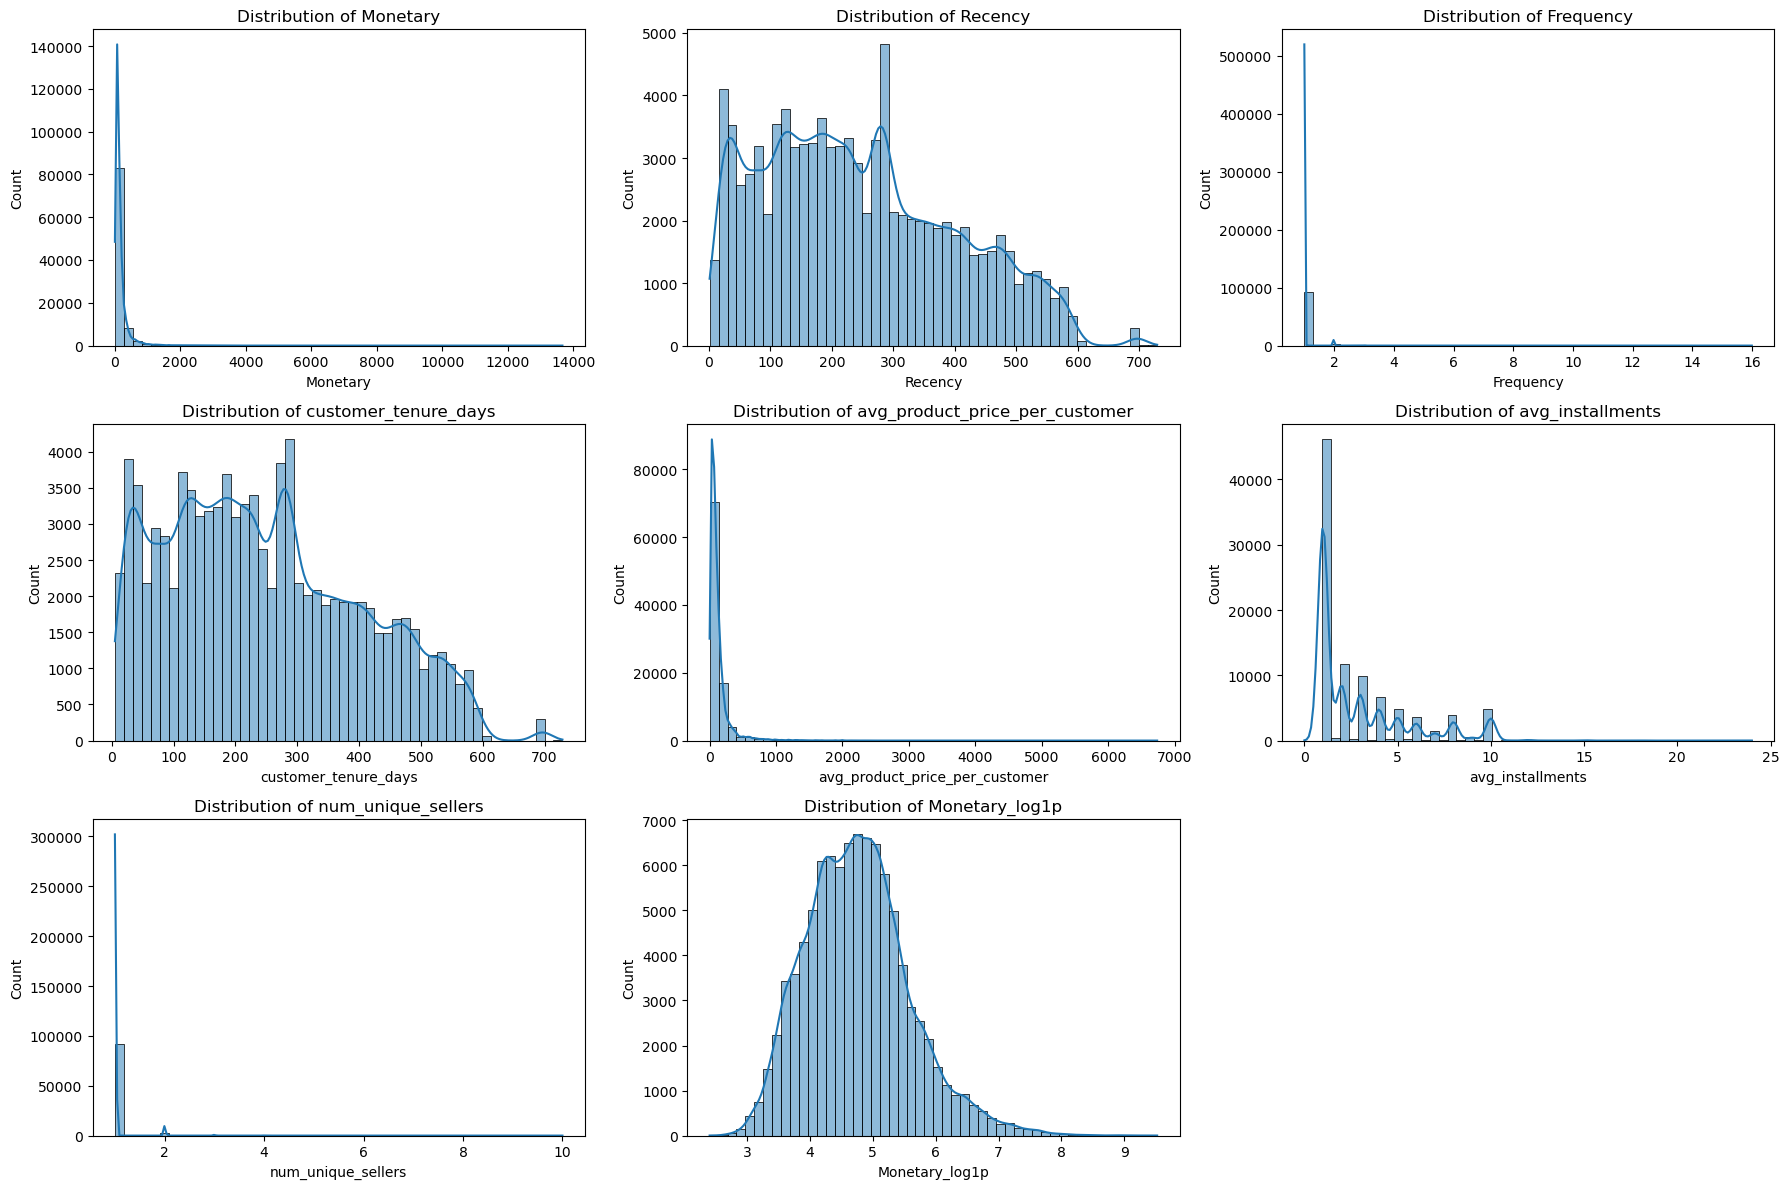

In [33]:
print("\nVisualizing Distributions of Key Numerical Features:")

numerical_features_to_plot = [
    'Monetary', 'Recency', 'Frequency', 'customer_tenure_days',
    'avg_product_price_per_customer', 'avg_installments', 'num_unique_sellers',
    'Monetary_log1p' # Ensure this is in the list
]

plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_features_to_plot):
    plt.subplot(3, 3, i + 1)
    if col in rfm_df.columns: # Added defensive check for plotting loop too
        sns.histplot(rfm_df[col], kde=True, bins=50)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
    else:
        print(f"DEBUG: Skipping plot for '{col}' as it's not in rfm_df.")
plt.tight_layout()
plt.show()

### Correlation Matrix (Heatmap)


In [34]:
print("\nVisualizing Correlation Matrix (including Monetary and new features):")
# Select relevant features for correlation heatmap (can be a subset for clarity)
correlation_features = [
    'Recency', 'Frequency', 'Monetary', 'customer_tenure_days',
    'average_review_score', 'num_unique_product_categories_purchased',
    'avg_product_price_per_customer', 'avg_freight_per_item',
    'avg_installments', 'max_installments', 'min_installments',
    'num_unique_sellers', 'avg_seller_review_score',
    'avg_purchased_category_price'
]



Visualizing Correlation Matrix (including Monetary and new features):


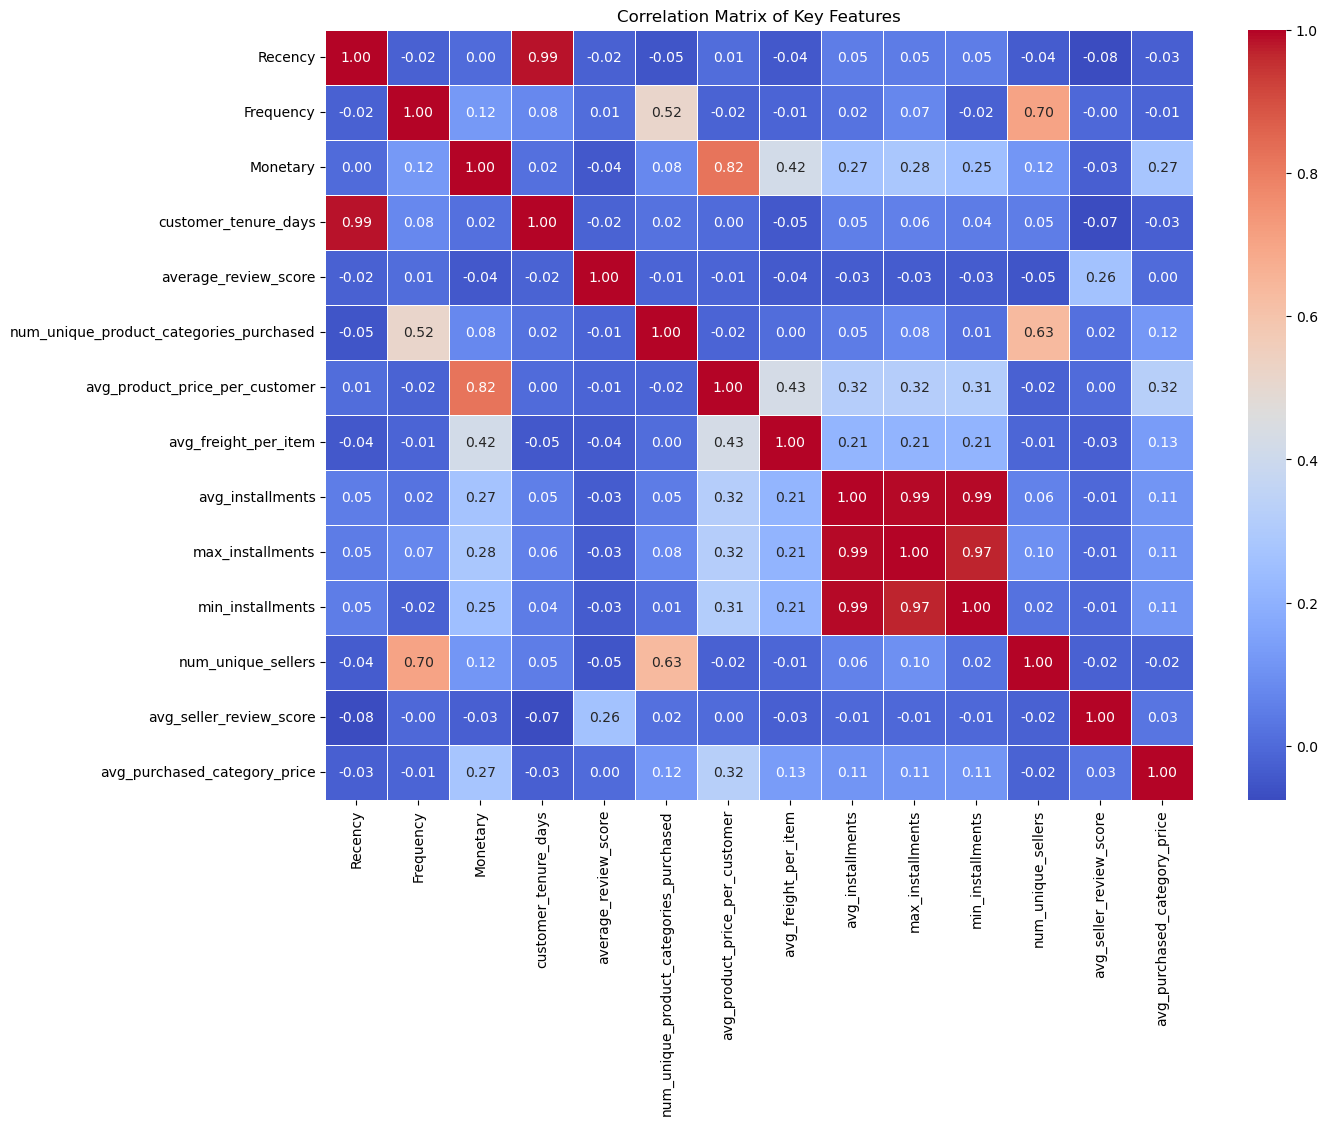

In [35]:
# Ensure all features exist before plotting
correlation_features = [f for f in correlation_features if f in rfm_df.columns]

plt.figure(figsize=(14, 10))
sns.heatmap(rfm_df[correlation_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Key Features')
plt.show()

### Visualize correlations with Log-transformed Monetary


In [36]:
print("\nCorrelations with Log-transformed Monetary:")
# Create a temporary df with transformed monetary
temp_corr_df_log = rfm_df[correlation_features].copy()
if 'Monetary' in temp_corr_df_log.columns: # Defensive check for Monetary existence
    temp_corr_df_log['Monetary_log1p'] = np.log1p(temp_corr_df_log['Monetary'])
    # Drop original Monetary from this temp df to avoid redundancy if not needed
    temp_corr_df_log.drop(columns=['Monetary'], inplace=True)
    print(temp_corr_df_log.corr()['Monetary_log1p'].sort_values(ascending=False))
else:
    print("   Cannot compute correlations with Monetary_log1p as 'Monetary' column is missing from temp_corr_df_log.")



Correlations with Log-transformed Monetary:
Monetary_log1p                             1.000000
avg_product_price_per_customer             0.692448
avg_freight_per_item                       0.456026
max_installments                           0.409028
avg_installments                           0.395520
min_installments                           0.377318
avg_purchased_category_price               0.258140
num_unique_sellers                         0.174739
Frequency                                  0.169373
num_unique_product_categories_purchased    0.123069
customer_tenure_days                       0.013077
Recency                                   -0.004525
avg_seller_review_score                   -0.012119
average_review_score                      -0.057733
Name: Monetary_log1p, dtype: float64


### Pair Plots for Key Relationships ( a few highly correlated ones)



Visualizing Pair Plots for Top Correlated Features with Log-transformed Monetary:


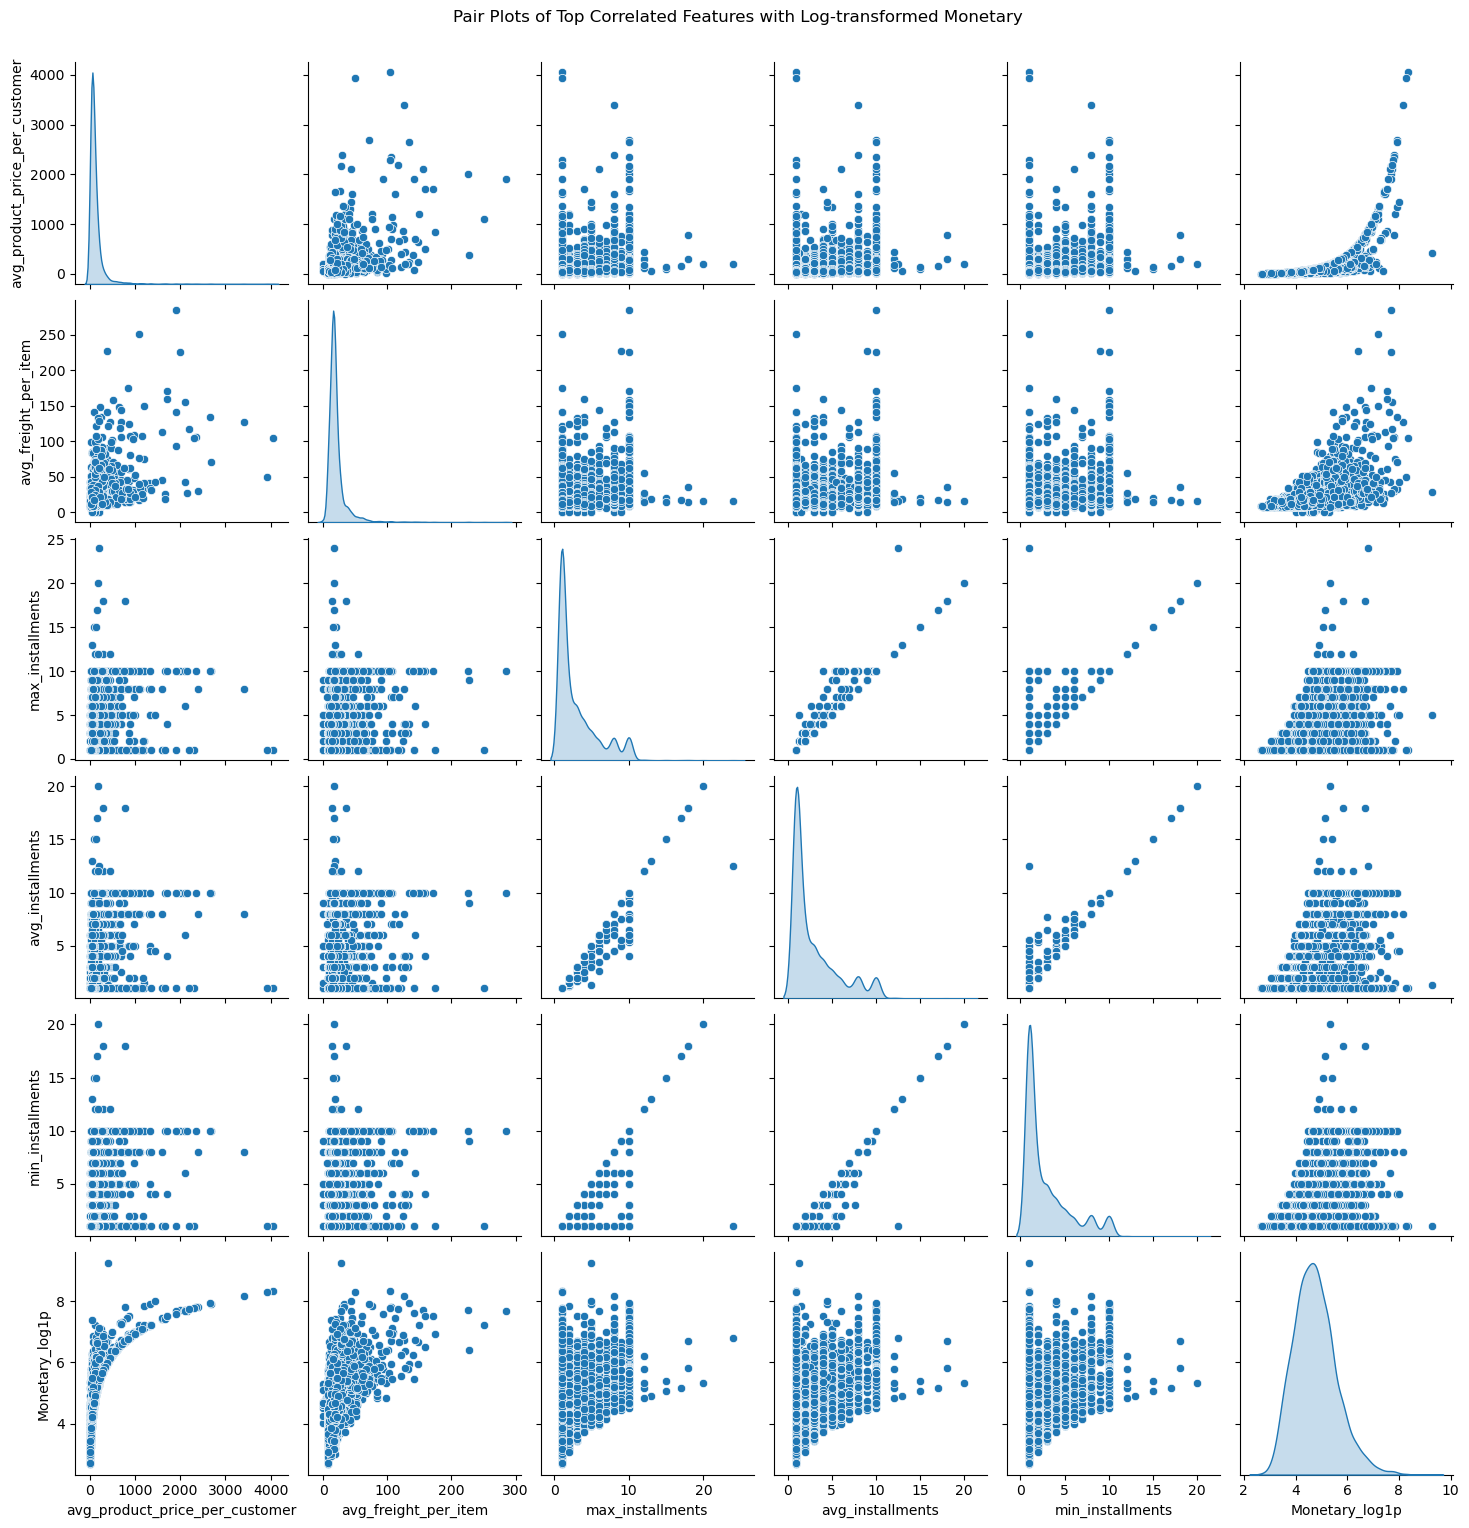

In [37]:
print("\nVisualizing Pair Plots for Top Correlated Features with Log-transformed Monetary:")
# Select features with highest absolute correlation with Monetary_log1p
if 'Monetary_log1p' in temp_corr_df_log.columns: # Ensure Monetary_log1p exists in temp_corr_df_log
    top_correlated_features = temp_corr_df_log.corr()['Monetary_log1p'].abs().sort_values(ascending=False).index.tolist()
    # Exclude Monetary_log1p itself and take top N (e.g., top 4 or 5)
    top_correlated_features = [f for f in top_correlated_features if f != 'Monetary_log1p' and f != 'Monetary']
    top_correlated_features_for_plot = top_correlated_features[:5] + ['Monetary_log1p']

    if len(top_correlated_features_for_plot) > 1:
        # Pass rfm_df directly to pairplot as Monetary_log1p is in it
        sns.pairplot(rfm_df[top_correlated_features_for_plot].sample(n=min(5000, len(rfm_df)), random_state=42), diag_kind='kde') # Sample for performance
        plt.suptitle('Pair Plots of Top Correlated Features with Log-transformed Monetary', y=1.02)
        plt.show()
    else:
        print("Not enough correlated features to create a pair plot.")
else:
    print("ERROR: Monetary_log1p not available for pair plots.")



### Box Plots for Categorical/Binary Features vs. Monetary (Log-transformed)



Visualizing Box Plots for Categorical/Binary Features vs. Log-transformed Monetary:


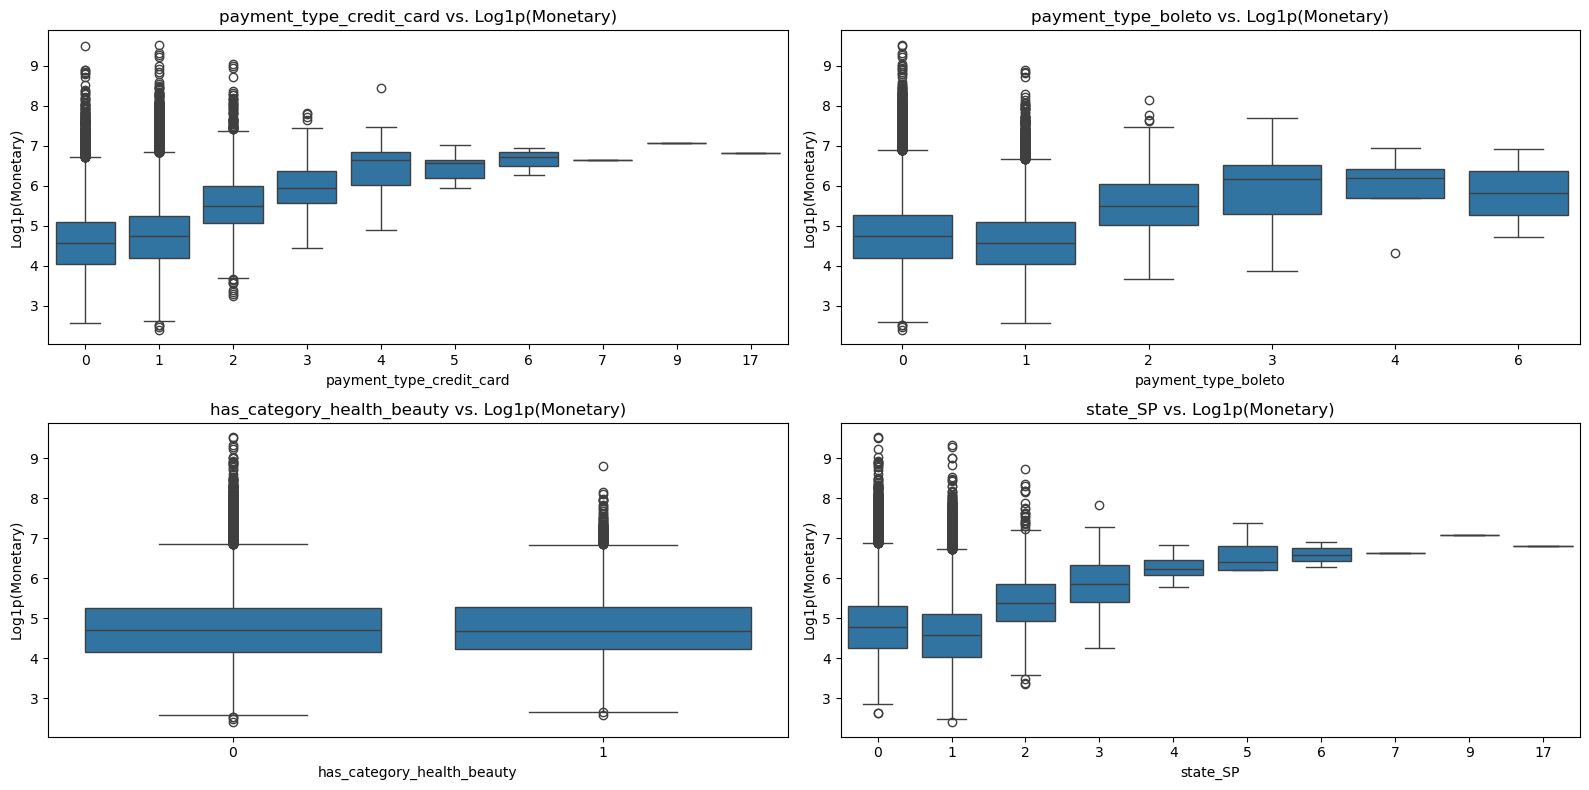

In [38]:
print("\nVisualizing Box Plots for Categorical/Binary Features vs. Log-transformed Monetary:")
categorical_features_to_plot = [
    'payment_type_credit_card', 'payment_type_boleto', 'has_category_health_beauty',
    'state_SP' # Example, pick a few impactful OHE states
]
categorical_features_to_plot = [f for f in categorical_features_to_plot if f in rfm_df.columns]

plt.figure(figsize=(16, 8))
if 'Monetary_log1p' in rfm_df.columns: # Ensure Monetary_log1p exists for these plots
    for i, col in enumerate(categorical_features_to_plot):
        if i < 4: # Limit to 4 plots per figure
            plt.subplot(2, 2, i + 1)
            sns.boxplot(x=col, y='Monetary_log1p', data=rfm_df)
            plt.title(f'{col} vs. Log1p(Monetary)')
            plt.xlabel(col)
            plt.ylabel('Log1p(Monetary)')
    plt.tight_layout()
    plt.show()
else:
    print("ERROR: Monetary_log1p not available for Box plots.")



### Scatter plot: Frequency vs. Log-transformed Monetary


In [39]:
print("\nVisualizing: Frequency vs. Log-transformed Monetary")
plt.figure(figsize=(10, 6))
# Sample the DataFrame first to ensure 'Monetary_log1p' is present in the sampled data
# DEBUGGING STEP 2: Check sampled_rfm_df_for_plot content
sampled_rfm_df_for_plot = rfm_df.sample(n=min(10000, len(rfm_df)), random_state=42)
print("\n--- DEBUG: sampled_rfm_df_for_plot.head() for scatter plot ---")
print(sampled_rfm_df_for_plot.head())
print("\n--- DEBUG: Columns in sampled_rfm_df_for_plot ---")
print(sampled_rfm_df_for_plot.columns.tolist())





Visualizing: Frequency vs. Log-transformed Monetary

--- DEBUG: sampled_rfm_df_for_plot.head() for scatter plot ---
                     customer_unique_id  Recency  Frequency  Monetary  \
32709  577b7f80f2468173232c5453fb614279      104          1    100.19   
85203  e4419ca71e493f57fce5809d2039e9ba      334          2    116.83   
86074  e6ae3727da5a849a77c47c7d661bd152       80          2    209.97   
85980  e675b8023b34348c55ec1ad0c6db84d8      118          1    119.39   
49798  85730e226e2f3a1608433546133793e1      302          2     85.09   

       customer_tenure_days  average_review_score  \
32709                   104              5.000000   
85203                   335              3.333333   
86074                    81              4.000000   
85980                   118              1.000000   
49798                   302              3.000000   

       num_unique_product_categories_purchased  \
32709                                        1   
85203                    

<Figure size 1000x600 with 0 Axes>

### Specific Plots

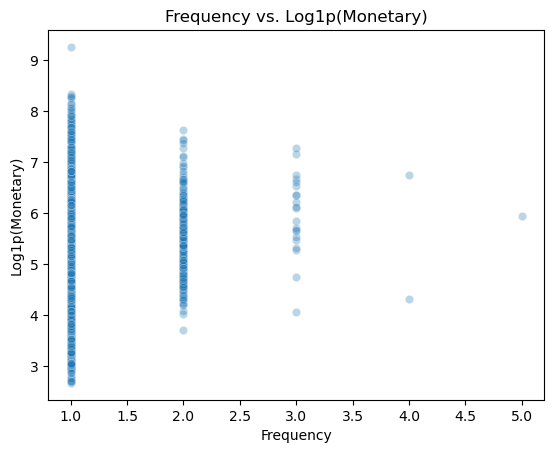

In [40]:
if 'Monetary_log1p' in sampled_rfm_df_for_plot.columns:
    sns.scatterplot(x='Frequency', y='Monetary_log1p', data=sampled_rfm_df_for_plot, alpha=0.3)
    plt.title('Frequency vs. Log1p(Monetary)')
    plt.xlabel('Frequency')
    plt.ylabel('Log1p(Monetary)')
    plt.show()
else:
    print("Error: 'Monetary_log1p' not found in sampled DataFrame for scatter plot. Please run all cells from top.")
    print("This indicates 'Monetary_log1p' was likely missing from rfm_df *before* sampling.")

### Bar Plot: Top N Product Categories by Total Monetary Value

In [41]:
print("\nVisualizing: Top N Product Categories by Total Monetary Value")
# Ensure that 'Monetary' column is available for master_df(its important)
# Recalculate total monetary value per English category from master_df
if 'Monetary' not in master_df.columns:
    # master_df['Monetary'] is price + freight_value at order_item level.
    master_df['Monetary'] = master_df['price'] + master_df['freight_value']
    print("Added 'Monetary' column to master_df for category analysis.")


Visualizing: Top N Product Categories by Total Monetary Value
Added 'Monetary' column to master_df for category analysis.


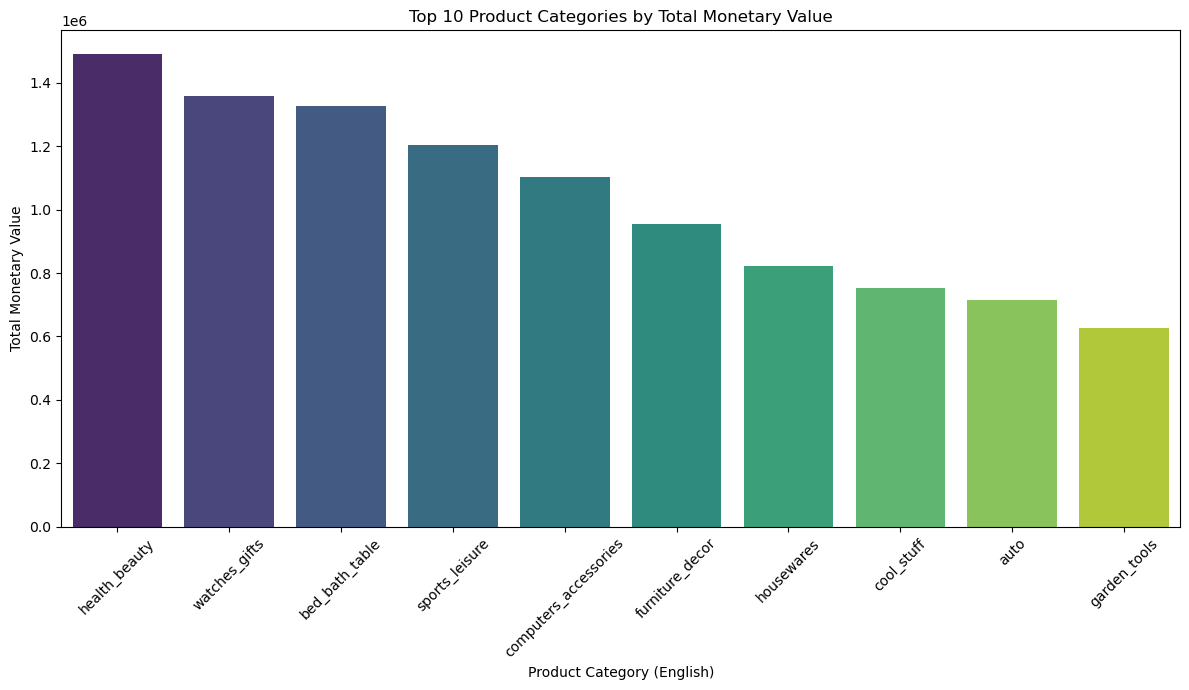

In [42]:
category_monetary_value = master_df.groupby('product_category_name_english')['Monetary'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 7))
sns.barplot(
    x=category_monetary_value.index,
    y=category_monetary_value.values,
    hue=category_monetary_value.index,
    palette='viridis',
    legend=False
)
plt.title('Top 10 Product Categories by Total Monetary Value')
plt.xlabel('Product Category (English)')
plt.ylabel('Total Monetary Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Distribution of Payment Installments


Visualizing: Distribution of Max Payment Installments per Customer


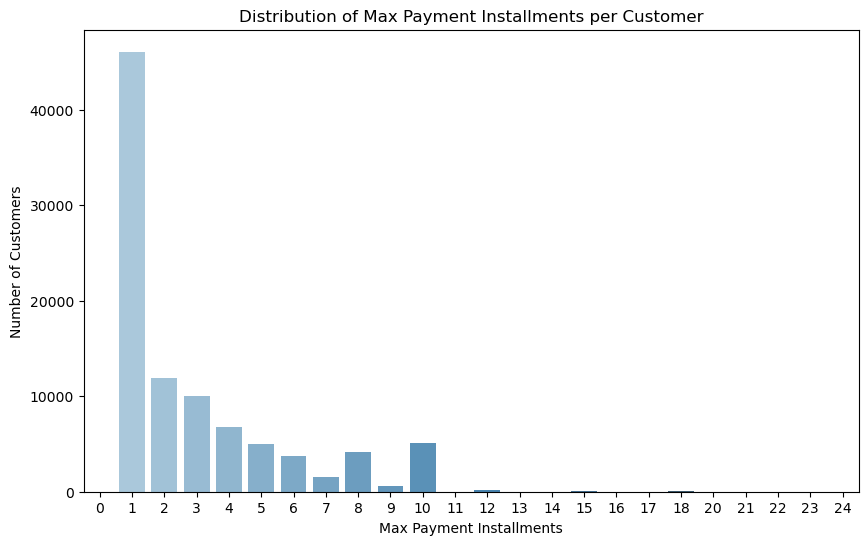

In [43]:
print("\nVisualizing: Distribution of Max Payment Installments per Customer")
plt.figure(figsize=(10, 6))
sns.countplot(x='max_installments', data=rfm_df.sort_values(by='max_installments'), 
              hue='max_installments', palette='Blues_d', legend=False)
plt.title('Distribution of Max Payment Installments per Customer')
plt.xlabel('Max Payment Installments')
plt.ylabel('Number of Customers')
plt.show()


In [44]:
rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary,customer_tenure_days,average_review_score,num_unique_product_categories_purchased,avg_product_price_per_customer,max_product_price_purchased,min_product_price_purchased,avg_freight_per_item,avg_installments,max_installments,min_installments,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,avg_purchased_category_price,has_category_health_beauty,has_category_computers_accessories,has_category_furniture_decor,has_category_auto,has_category_telephony,avg_items_per_order,num_unique_sellers,avg_seller_review_score,state_AC,state_AL,state_AM,state_AP,state_BA,state_CE,state_DF,state_ES,state_GO,state_MA,state_MG,state_MS,state_MT,state_PA,state_PB,state_PE,state_PI,state_PR,state_RJ,state_RN,state_RO,state_RR,state_RS,state_SC,state_SE,state_SP,state_TO,Monetary_log1p
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,116,5.0,1,129.90,129.90,129.90,12.00,8.0,8,8,0,1,0,0,0,93.296327,0,0,0,0,0,1.0,1,4.056558,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4.962145
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,119,4.0,1,18.90,18.90,18.90,8.29,1.0,1,1,0,1,0,0,0,130.163531,1,0,0,0,0,1.0,1,3.982759,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.338967
2,0000f46a3911fa3c0805444483337064,542,1,86.22,542,3.0,1,69.00,69.00,69.00,17.22,8.0,8,8,0,1,0,0,0,91.753369,0,0,0,0,0,1.0,1,4.076349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4.468434
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,326,4.0,1,25.99,25.99,25.99,17.63,4.0,4,4,0,1,0,0,0,71.213978,0,0,0,0,1,1.0,1,3.882521,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3.798182
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,293,5.0,1,180.00,180.00,180.00,16.89,6.0,6,6,0,1,0,0,0,71.213978,0,0,0,0,1,1.0,1,3.761364,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5.287711


In [45]:
rfm_df['Monetary_log1p'] = np.log1p(rfm_df['Monetary'])
rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary,customer_tenure_days,average_review_score,num_unique_product_categories_purchased,avg_product_price_per_customer,max_product_price_purchased,min_product_price_purchased,avg_freight_per_item,avg_installments,max_installments,min_installments,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,avg_purchased_category_price,has_category_health_beauty,has_category_computers_accessories,has_category_furniture_decor,has_category_auto,has_category_telephony,avg_items_per_order,num_unique_sellers,avg_seller_review_score,state_AC,state_AL,state_AM,state_AP,state_BA,state_CE,state_DF,state_ES,state_GO,state_MA,state_MG,state_MS,state_MT,state_PA,state_PB,state_PE,state_PI,state_PR,state_RJ,state_RN,state_RO,state_RR,state_RS,state_SC,state_SE,state_SP,state_TO,Monetary_log1p
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,116,5.0,1,129.90,129.90,129.90,12.00,8.0,8,8,0,1,0,0,0,93.296327,0,0,0,0,0,1.0,1,4.056558,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4.962145
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,119,4.0,1,18.90,18.90,18.90,8.29,1.0,1,1,0,1,0,0,0,130.163531,1,0,0,0,0,1.0,1,3.982759,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.338967
2,0000f46a3911fa3c0805444483337064,542,1,86.22,542,3.0,1,69.00,69.00,69.00,17.22,8.0,8,8,0,1,0,0,0,91.753369,0,0,0,0,0,1.0,1,4.076349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4.468434
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,326,4.0,1,25.99,25.99,25.99,17.63,4.0,4,4,0,1,0,0,0,71.213978,0,0,0,0,1,1.0,1,3.882521,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3.798182
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,293,5.0,1,180.00,180.00,180.00,16.89,6.0,6,6,0,1,0,0,0,71.213978,0,0,0,0,1,1.0,1,3.761364,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5.287711


### Violin Plot: Average Review Score vs. Log-transformed Monetary


Visualizing: Average Review Score vs. Log-transformed Monetary


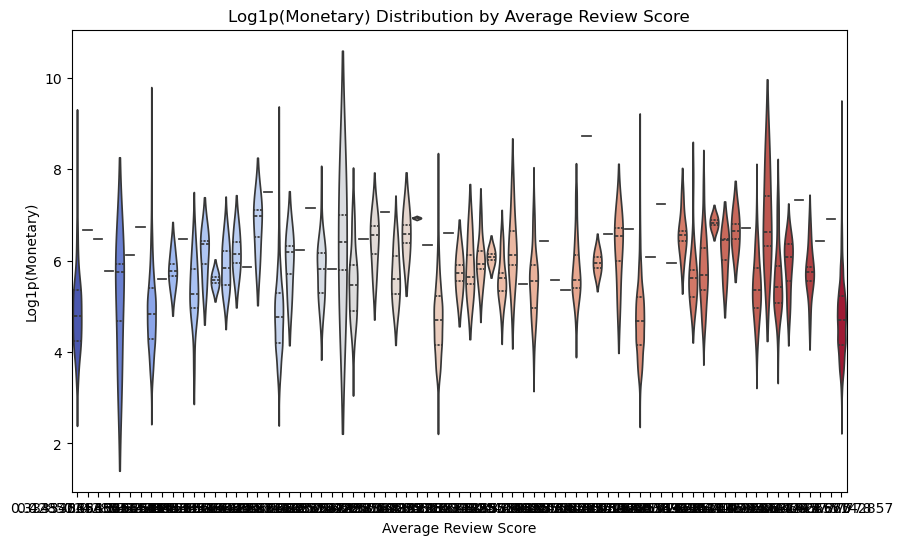

In [46]:
print("\nVisualizing: Average Review Score vs. Log-transformed Monetary")
plt.figure(figsize=(10, 6))

sns.violinplot(x='average_review_score', y='Monetary_log1p', data=rfm_df, inner='quartile', 
                hue='average_review_score', palette='coolwarm', legend=False)
plt.title('Log1p(Monetary) Distribution by Average Review Score')
plt.xlabel('Average Review Score')
plt.ylabel('Log1p(Monetary)')
plt.show()
# else:
  #  print("DEBUG: Monetary_log1p not available for Violin plot.")






In [47]:
# Drop temporary log1p column before saving
if 'Monetary_log1p' in rfm_df.columns:
    rfm_df.drop(columns=['Monetary_log1p'], inplace=True)
    print("\nDropped temporary 'Monetary_log1p' column.")
else:
    print("\n'Monetary_log1p' column not found, skipping drop.")

print("\n--- In-Depth EDA Complete ---")


Dropped temporary 'Monetary_log1p' column.

--- In-Depth EDA Complete ---


In [48]:
rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary,customer_tenure_days,average_review_score,num_unique_product_categories_purchased,avg_product_price_per_customer,max_product_price_purchased,min_product_price_purchased,avg_freight_per_item,avg_installments,max_installments,min_installments,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,avg_purchased_category_price,has_category_health_beauty,has_category_computers_accessories,has_category_furniture_decor,has_category_auto,has_category_telephony,avg_items_per_order,num_unique_sellers,avg_seller_review_score,state_AC,state_AL,state_AM,state_AP,state_BA,state_CE,state_DF,state_ES,state_GO,state_MA,state_MG,state_MS,state_MT,state_PA,state_PB,state_PE,state_PI,state_PR,state_RJ,state_RN,state_RO,state_RR,state_RS,state_SC,state_SE,state_SP,state_TO
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,116,5.0,1,129.90,129.90,129.90,12.00,8.0,8,8,0,1,0,0,0,93.296327,0,0,0,0,0,1.0,1,4.056558,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,119,4.0,1,18.90,18.90,18.90,8.29,1.0,1,1,0,1,0,0,0,130.163531,1,0,0,0,0,1.0,1,3.982759,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0000f46a3911fa3c0805444483337064,542,1,86.22,542,3.0,1,69.00,69.00,69.00,17.22,8.0,8,8,0,1,0,0,0,91.753369,0,0,0,0,0,1.0,1,4.076349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,326,4.0,1,25.99,25.99,25.99,17.63,4.0,4,4,0,1,0,0,0,71.213978,0,0,0,0,1,1.0,1,3.882521,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,293,5.0,1,180.00,180.00,180.00,16.89,6.0,6,6,0,1,0,0,0,71.213978,0,0,0,0,1,1.0,1,3.761364,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [49]:

# --- Final Checks and Save ---
print("\n--- Final RFM DataFrame (with Advanced Features) ---")
print(rfm_df.head())
print(rfm_df.info())
print(f"Final rfm_df shape: {rfm_df.shape}")
nan_count_final = rfm_df.isnull().sum().sum()
print(f"Number of remaining NaNs in final rfm_df: {nan_count_final}")
if nan_count_final == 0:
    print("No NaNs remaining. DataFrame is clean.")
else:
    print("WARNING: Some NaNs still present. Review previous steps.")
    print(rfm_df.isnull().sum()[rfm_df.isnull().sum() > 0]) # Show columns with NaNs



print("\n--- Phase 2: Feature Engineering & EDA (Revised with Advanced Features) Complete ---")


--- Final RFM DataFrame (with Advanced Features) ---
                 customer_unique_id  Recency  Frequency  Monetary  \
0  0000366f3b9a7992bf8c76cfdf3221e2      116          1    141.90   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      119          1     27.19   
2  0000f46a3911fa3c0805444483337064      542          1     86.22   
3  0000f6ccb0745a6a4b88665a16c9f078      326          1     43.62   
4  0004aac84e0df4da2b147fca70cf8255      293          1    196.89   

   customer_tenure_days  average_review_score  \
0                   116                   5.0   
1                   119                   4.0   
2                   542                   3.0   
3                   326                   4.0   
4                   293                   5.0   

   num_unique_product_categories_purchased  avg_product_price_per_customer  \
0                                        1                          129.90   
1                                        1                           18.90   
2 

In [50]:
import os

# Define directory path
output_dir = '/Users/apple/Documents/data projects/new'

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)


In [51]:
output_path1 = os.path.join(output_dir, 'olist_master_dataframe_features_new.csv')
output_path2 = os.path.join(output_dir, 'olist_customer_segments_enriched.csv')

master_df.to_csv(output_path1, index=False)
rfm_df.to_csv(output_path2, index=False)

print("Feature-engineered DataFrames are saved successfully.")

Feature-engineered DataFrames are saved successfully.


In [52]:
rfm_df.head()

,customer_unique_id,Recency,Frequency,Monetary,customer_tenure_days,average_review_score,num_unique_product_categories_purchased,avg_product_price_per_customer,max_product_price_purchased,min_product_price_purchased,avg_freight_per_item,avg_installments,max_installments,min_installments,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_not_defined,payment_type_voucher,avg_purchased_category_price,has_category_health_beauty,has_category_computers_accessories,has_category_furniture_decor,has_category_auto,has_category_telephony,avg_items_per_order,num_unique_sellers,avg_seller_review_score,state_AC,state_AL,state_AM,state_AP,state_BA,state_CE,state_DF,state_ES,state_GO,state_MA,state_MG,state_MS,state_MT,state_PA,state_PB,state_PE,state_PI,state_PR,state_RJ,state_RN,state_RO,state_RR,state_RS,state_SC,state_SE,state_SP,state_TO
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,116,5.0,1,129.90,129.90,129.90,12.00,8.0,8,8,0,1,0,0,0,93.296327,0,0,0,0,0,1.0,1,4.056558,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,119,4.0,1,18.90,18.90,18.90,8.29,1.0,1,1,0,1,0,0,0,130.163531,1,0,0,0,0,1.0,1,3.982759,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0000f46a3911fa3c0805444483337064,542,1,86.22,542,3.0,1,69.00,69.00,69.00,17.22,8.0,8,8,0,1,0,0,0,91.753369,0,0,0,0,0,1.0,1,4.076349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,326,4.0,1,25.99,25.99,25.99,17.63,4.0,4,4,0,1,0,0,0,71.213978,0,0,0,0,1,1.0,1,3.882521,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,293,5.0,1,180.00,180.00,180.00,16.89,6.0,6,6,0,1,0,0,0,71.213978,0,0,0,0,1,1.0,1,3.761364,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [53]:
rfm_df.shape

(95419, 55)

In [54]:
master_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state,Monetary
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11,2017-10-12 03:43:48,1.0,credit_card,1.0,18.12,9350.0,maua,SP,38.71
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11,2017-10-12 03:43:48,3.0,voucher,1.0,2.00,9350.0,maua,SP,38.71
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11,2017-10-12 03:43:48,2.0,voucher,1.0,18.59,9350.0,maua,SP,38.71
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,perfumery,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08,2018-08-08 18:37:50,1.0,boleto,1.0,141.46,31570.0,belo horizonte,SP,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0,auto,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18,2018-08-22 19:07:58,1.0,credit_card,3.0,179.12,14840.0,guariba,SP,179.12


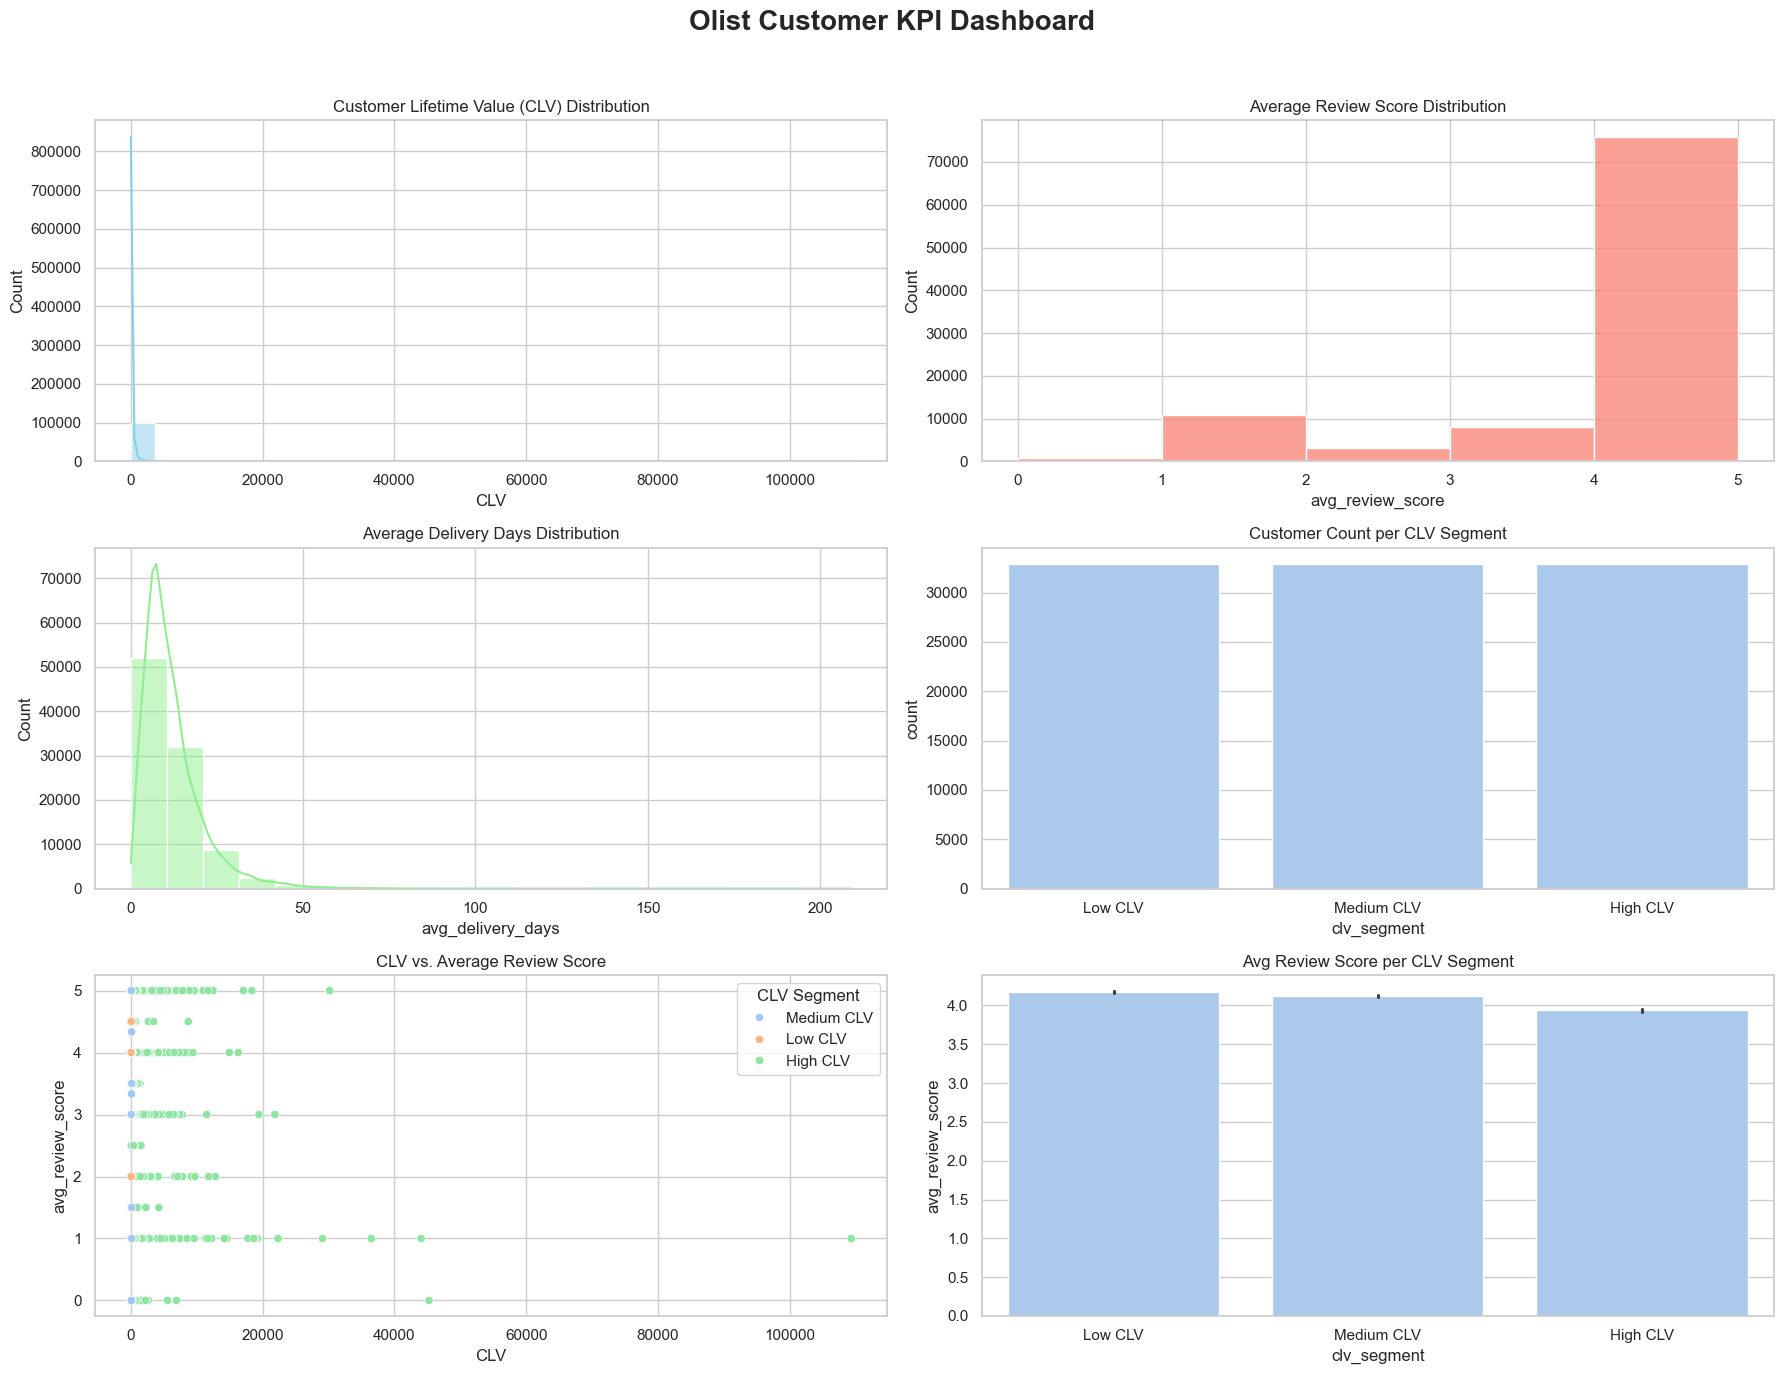

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your final KPI dataset
kpi_df = pd.read_csv("olist_customer_kpis_final.csv")

# Set seaborn theme
sns.set(style="whitegrid", palette="pastel")

# Setup the dashboard layout
fig, axs = plt.subplots(3, 2, figsize=(18, 14))
fig.suptitle('Olist Customer KPI Dashboard', fontsize=20, fontweight='bold')

# --- 1. CLV Distribution ---
sns.histplot(kpi_df['CLV'], bins=30, kde=True, ax=axs[0, 0], color='skyblue')
axs[0, 0].set_title("Customer Lifetime Value (CLV) Distribution")

# --- 2. Review Score Distribution ---
sns.histplot(kpi_df['avg_review_score'], bins=5, kde=False, ax=axs[0, 1], color='salmon')
axs[0, 1].set_title("Average Review Score Distribution")

# --- 3. Delivery Days Distribution ---
sns.histplot(kpi_df['avg_delivery_days'], bins=20, kde=True, ax=axs[1, 0], color='lightgreen')
axs[1, 0].set_title("Average Delivery Days Distribution")

# --- 4. CLV Segment Count ---
sns.countplot(x='clv_segment', data=kpi_df, ax=axs[1, 1], order=['Low CLV', 'Medium CLV', 'High CLV'])
axs[1, 1].set_title("Customer Count per CLV Segment")

# --- 5. CLV vs Satisfaction (Scatter) ---
sns.scatterplot(x='CLV', y='avg_review_score', data=kpi_df, ax=axs[2, 0], hue='clv_segment')
axs[2, 0].set_title("CLV vs. Average Review Score")
axs[2, 0].legend(title='CLV Segment')

# --- 6. Avg Review Score by CLV Segment ---
sns.barplot(x='clv_segment', y='avg_review_score', data=kpi_df, ax=axs[2, 1], order=['Low CLV', 'Medium CLV', 'High CLV'])
axs[2, 1].set_title("Avg Review Score per CLV Segment")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming master_df is already defined and cleaned
df = master_df.copy()

# Total monetary value per order
df['order_value'] = df['price'] + df['freight_value']

# CLV (simple): Total value per customer
clv_df = df.groupby('customer_id')['order_value'].sum().reset_index(name='CLV')

# Average Review Score per customer
review_df = df.groupby('customer_id')['review_score'].mean().reset_index(name='avg_review_score')

# Delivery duration (in days)
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['delivery_days'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

# Avg delivery duration
avg_delivery = df['delivery_days'].mean()

# Merge CLV and review score for plotting
kpi_df = clv_df.merge(review_df, on='customer_id')


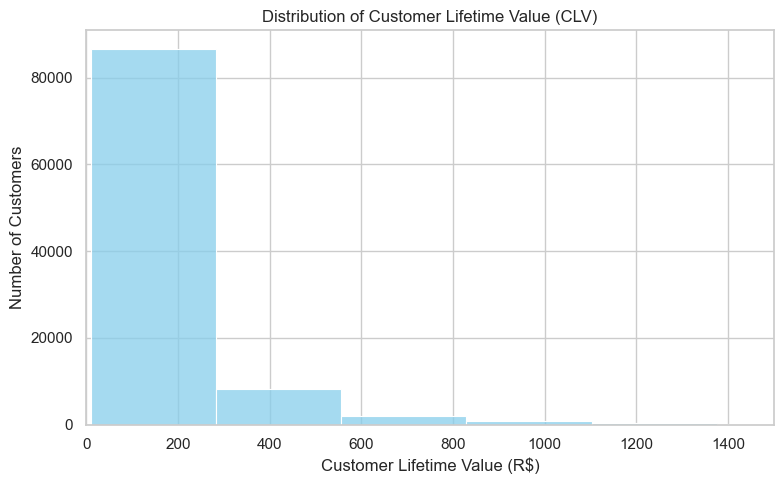

In [77]:
plt.figure(figsize=(8, 5))
sns.histplot(kpi_df['CLV'], bins=50, kde=False, color='skyblue')
plt.title("Distribution of Customer Lifetime Value (CLV)")
plt.xlabel("Customer Lifetime Value (R$)")
plt.ylabel("Number of Customers")
plt.xlim(0, 1500)  # Adjust this based on your outliers
plt.grid(True)
plt.tight_layout()
plt.show()


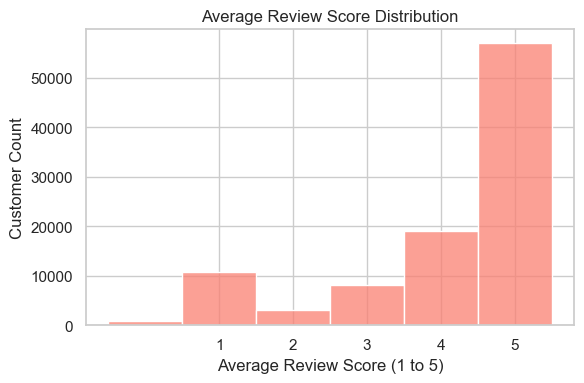

In [70]:
plt.figure(figsize=(6, 4))
sns.histplot(kpi_df['avg_review_score'], bins=5, discrete=True, color='salmon')
plt.title("Average Review Score Distribution")
plt.xlabel("Average Review Score (1 to 5)")
plt.ylabel("Customer Count")
plt.xticks([1, 2, 3, 4, 5])
plt.grid(True)
plt.tight_layout()
plt.show()


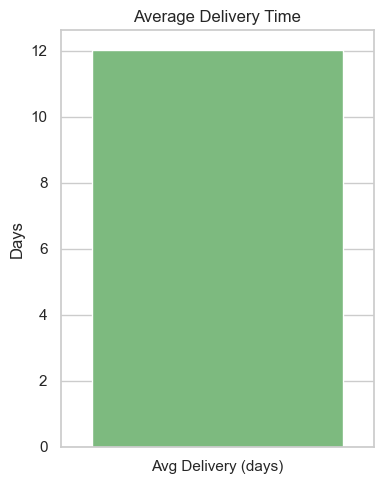

In [72]:
plt.figure(figsize=(4, 5))
sns.barplot(x=["Avg Delivery (days)"], y=[avg_delivery], hue=["Avg Delivery (days)"],
            palette="Greens", legend=False)
plt.title("Average Delivery Time")
plt.ylabel("Days")
plt.tight_layout()
plt.show()


/var/folders/bh/xm6__g3d49j0j4s_ygs9754w0000gn/T/ipykernel_9108/2562243147.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=kpi_df, x='clv_segment', palette="Blues")


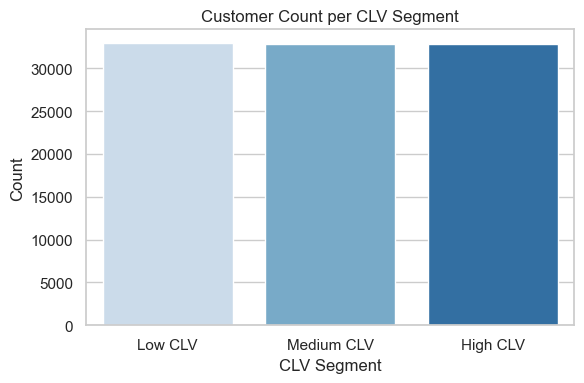

In [73]:
# Segmenting CLV into 3 equal bins
kpi_df['clv_segment'] = pd.qcut(kpi_df['CLV'], q=3, labels=['Low CLV', 'Medium CLV', 'High CLV'])

plt.figure(figsize=(6, 4))
sns.countplot(data=kpi_df, x='clv_segment', palette="Blues")
plt.title("Customer Count per CLV Segment")
plt.xlabel("CLV Segment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [75]:
print("📌 Key KPIs Summary:")
print(f"Average CLV: R${kpi_df['CLV'].mean():,.2f}")
print(f"Average Review Score: {kpi_df['avg_review_score'].mean():.2f}")
print(f"Average Delivery Time: {avg_delivery:.2f} days")
print(f"High CLV Customers (%): {round((kpi_df['clv_segment'] == 'High CLV').mean() * 100, 2)}%")


📌 Key KPIs Summary:
Average CLV: R$168.69
Average Review Score: 4.07
Average Delivery Time: 12.02 days
High CLV Customers (%): 33.33%
